In [5]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [6]:
os.getcwd()

'/Users/raimon/Desktop/Github_repo'

In [7]:
# import data
data = pd.read_csv('/Users/raimon/Desktop/Github_repo/lait_equitable/data/Données_marché_Lait.csv')
print('Dataset length:', len(data))
data.head()

Dataset length: 10898


,Date,Composants de coûts,Devise,Type de données,Source de données,Commerce extérieur,Indicateur,Marché,Produit,Groupe de produits,Système de production,Provenance du produit,Propriétés du produit,Sous-groupe de produits,Région de vente,Unité,Mode d’utilisation,Echelon de création de valeur_Détail,Echelon de création de valeur,Prix
0,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,Lait de centrale (conventionnel),Lait cru,Conventionnel,Région 2,NaN,Lait cru CH,Suisse,kg,NaN,Au départ de la ferme (échelon de la production),Production,70.590753
1,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,Lait de prairie IP Suisse,Lait cru,IP Suisse,Suisse,NaN,Lait cru CH,Suisse,kg,Lait cru sans définition supplémentaire,Au départ de la ferme (échelon de la production),Production,76.338026
2,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,Lait transformé en fromage (conventionnel),Lait cru,Conventionnel,Suisse,NaN,Lait cru CH,Suisse,kg,NaN,Au départ de la ferme (échelon de la production),Production,77.631932
3,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,"Lait CH, total",Lait cru,NaN,Région 5,NaN,Lait cru CH,Suisse,kg,NaN,Au départ de la ferme (échelon de la production),Production,77.900726
4,01-2024,NaN,Centimes,Prix indicatif,IPL,NaN,Prix,Lait et produits laitiers,"Lait conventionnel, total",Lait cru,Conventionnel,Suisse,NaN,Lait cru CH,Suisse,kg,segment A,Production non définie,Production,79.000000


In [8]:
# Check the number of unique values in each column
data.nunique()

Date                                      277
Composants de coûts                         2
Devise                                      1
Type de données                             2
Source de données                           8
Commerce extérieur                          0
Indicateur                                  1
Marché                                      1
Produit                                    20
Groupe de produits                          1
Système de production                       3
Provenance du produit                      14
Propriétés du produit                       0
Sous-groupe de produits                     2
Région de vente                             8
Unité                                       1
Mode d’utilisation                          3
Echelon de création de valeur_Détail        2
Echelon de création de valeur               1
Prix                                    10334
dtype: int64

WRANGLING & CLEANING 

Nous allons commencer par retirer les colonnes de ce data set qui n'apportent rien à notre analyse, donc toutes les colonnes présentant des valeurs uniques. 


In [9]:
# At this point you can remove column with unique values which are not useful and does not 
# provide information for the analysis for example Devise and Groupe de produit
# ATENTION il faut bien retenir que la devise est en centimes pour l'analyse
clean_data = data.copy()
# drop columns
clean_data = clean_data.drop(['Devise', 'Groupe de produits', 'Commerce extérieur', 'Indicateur',\
                   'Marché', 'Propriétés du produit', 'Unité', 'Echelon de création de valeur '], axis=1)

clean_data.head()

,Date,Composants de coûts,Type de données,Source de données,Produit,Système de production,Provenance du produit,Sous-groupe de produits,Région de vente,Mode d’utilisation,Echelon de création de valeur_Détail,Prix
0,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché",Lait de centrale (conventionnel),Conventionnel,Région 2,Lait cru CH,Suisse,NaN,Au départ de la ferme (échelon de la production),70.590753
1,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché",Lait de prairie IP Suisse,IP Suisse,Suisse,Lait cru CH,Suisse,Lait cru sans définition supplémentaire,Au départ de la ferme (échelon de la production),76.338026
2,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché",Lait transformé en fromage (conventionnel),Conventionnel,Suisse,Lait cru CH,Suisse,NaN,Au départ de la ferme (échelon de la production),77.631932
3,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché","Lait CH, total",NaN,Région 5,Lait cru CH,Suisse,NaN,Au départ de la ferme (échelon de la production),77.900726
4,01-2024,NaN,Prix indicatif,IPL,"Lait conventionnel, total",Conventionnel,Suisse,Lait cru CH,Suisse,segment A,Production non définie,79.000000


On va regarder les NaN et on va les remplacer ou simplement les enlever selon l'info qu'on tire :

In [10]:
# show unique values in each column
columns = ['Composants de coûts', 'Type de données', 'Source de données', 'Système de production',\
            'Provenance du produit', 'Sous-groupe de produits', 'Région de vente', 'Mode d’utilisation', 'Echelon de création de valeur_Détail']
for col in columns:
    print(col, clean_data[col].unique(), '\n')


Composants de coûts ['TVA incluse' nan 'Hors TVA'] 

Type de données ['Valeur réalisée' 'Prix indicatif'] 

Source de données ['OFAG, secteur Analyses du marché' 'IPL' 'CLAL Italien' 'IFE'
 'France Agrimer' 'AMA Österreich' 'BLE Deutschland'
 'Commission européenne'] 

Système de production ['Conventionnel' 'IP Suisse' nan 'Bio'] 

Provenance du produit ['Région 2' 'Suisse' 'Région 5' 'Région 1' 'Italie'
 'Reste du monde, non suisse' 'Région 4' 'Région 3' 'France'
 'Nouvelle-Zélande' 'USA / Canada' 'Autriche' 'Allemagne' 'UE'] 

Sous-groupe de produits ['Lait cru CH' 'Lait cru, International'] 

Région de vente ['Suisse' 'Italie' nan 'France' 'Nouvelle-Zélande' 'USA' 'Autriche'
 'Allemagne' 'UE-28'] 

Mode d’utilisation [nan 'Lait cru sans définition supplémentaire' 'segment A' 'segment B'] 

Echelon de création de valeur_Détail ['Au départ de la ferme (échelon de la production)'
 'Production non définie'] 



Composants de coûts       676
Système de production    4092
Région de vente           205
Mode d’utilisation       1577
dtype: int64


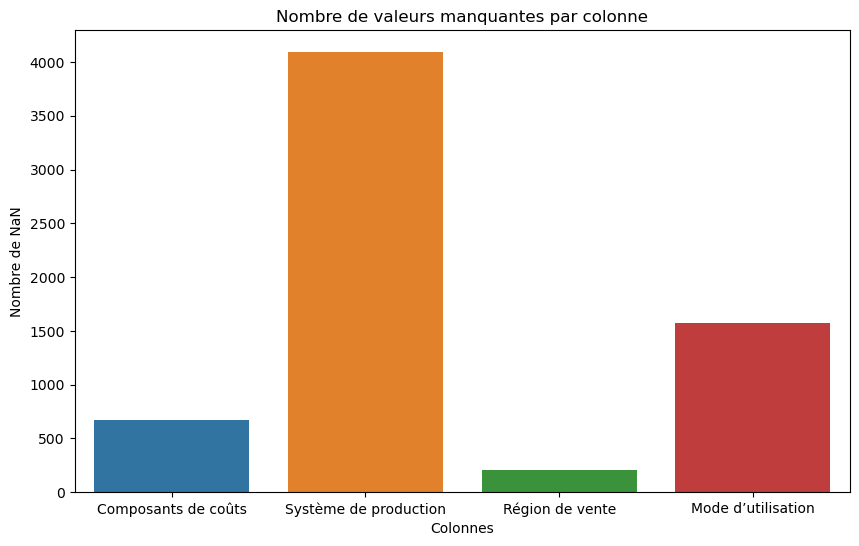

In [11]:
# Calculer le nombre de NaN pour chaque colonne et filtrer celles sans NaN
nan_counts = clean_data.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print(nan_counts)

# Créer un barplot pour visualiser les données manquantes
plt.figure(figsize=(10, 6))
sns.barplot(x=nan_counts.index, y=nan_counts.values)
plt.title('Nombre de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de NaN')

plt.show()

On remarque que les colonnes présentant des valeurs manquantes sont : Composants de coûts, Système de production, Région de vente et Mode d'utilisation.

In [12]:
# Calculer le pourcentage de NaN pour chaque colonne
nan_percent = clean_data.isna().mean() * 100

# Filtrer pour garder seulement les colonnes avec NaN
nan_percent = nan_percent[nan_percent > 0].reset_index()
nan_percent.columns = ['Colonne', 'Pourcentage de NaN']

# Créer un graphique interactif avec Plotly
fig = px.bar(nan_percent, x='Colonne', y='Pourcentage de NaN',
             text='Pourcentage de NaN')

# Mise à jour du graphique pour afficher le texte au-dessus des barres
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Mise à jour de l'axe des ordonnées pour afficher jusqu'à 100%
fig.update_yaxes(range=[0, 100])

# Mise à jour du layout pour une meilleure lisibilité
fig.update_layout(title_text='Pourcentage de valeurs manquantes par colonne',
                  yaxis_title='Pourcentage de NaN',
                  xaxis_title='Colonne')

# Afficher le graphique
fig.show()

The columns with missing values are: Cost components, Production system, Sales region and Use mode.
The 'Production system' variable has a higher percentage of missing values, around 37.6%. However, this is a key variable in our analysis so we keep it and replace missing information 'NaN' with 'Unknown' for clarity. 
As for the other characteristics, their percentage of missing values is relatively low thus we keep them too.

Dans cet histogramme, le pourcentage de valeurs manquantes n'est pas assez élevé pour que supprimer ces caractéristiques. De plus, le Système de production est une caractéristique importante pour ce projet.

Nous voulons analyser le commerce de lait en Suisse, c'est pour cela que nous allons créer une nouvelle variable incluant toutes les régions suisses où le lait est produit puis vendu. 

Nous allons garder toutes les régions suisses de la colonne "provenance du produit" et ne pas garder les autres régions non suisses. 
Nous allons garder toutes les régions suisses de la colonne "région de vente" et ne pas garder les autres régions non suisses.

In [13]:
# créer une nouvelle variable incluant toutes les régions suisses
swiss_production_data = ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5'] 
# Après c'est bien de revenir la dessus et de faire une analyse après avec le reste des pays pour comparer la suisse avec les autres pays

# filter data to keep only switzerland production
swiss_production_data = clean_data[clean_data['Provenance du produit'].isin(swiss_production_data)]

# Replace nan in the whole dataset with 'unknown'
swiss_production_data = swiss_production_data.fillna('unknown')

# Convert date from string to datetime
swiss_production_data['Date'] = pd.to_datetime(swiss_production_data['Date'])

print(swiss_production_data['Région de vente'].unique())
# Le fait que Region de vente n'ait plus qu'une valeur unique signifie que tout le lait produit en suisse est vendu en suisse
# C'est une colonne avec plus qu'une seule info donc on peut potentiellement la supprimer, c'est pour ca que c'est en blanc dans le correlation plot
# IDEM pour sous groupe de produits
len(swiss_production_data)

# Sauvegarder le nouvel ensemble de données dans un nouveau fichier CSV
swiss_production_data.to_csv('Swiss_Production.csv', index=False)

['Suisse']


/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_57337/1362209068.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



The milk sold in Switzerland comes from 14 different places - 14 values in 'Origin of product'. It would be interesting to see the distribution of milk in Switzerland, with the percentage of milk coming from Switzerland and the percentage coming from abroad.

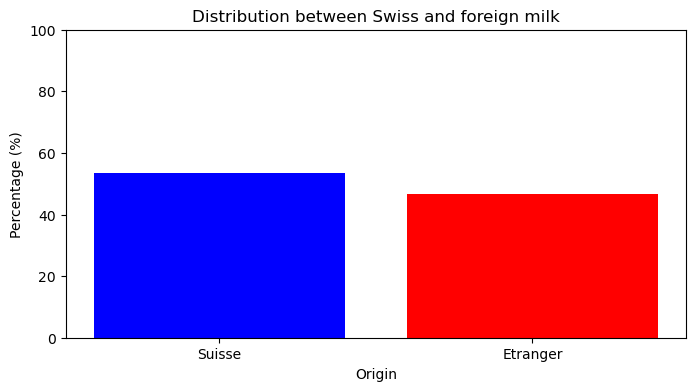

Provenance
Suisse      53.376766
Etranger    46.623234
Name: proportion, dtype: float64


In [14]:
# créer une nouvelle variable incluant toutes les régions suisses
swiss_production_data = ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5'] 

# Créer une nouvelle colonne pour la classification
clean_data['Provenance'] = clean_data['Provenance du produit'].apply(lambda x: 'Suisse' if x in swiss_production_data else 'Etranger')

# Calculer les pourcentages
category_counts = clean_data['Provenance'].value_counts(normalize=True) * 100

# Créer un diagramme à barres pour visualiser les pourcentages
plt.figure(figsize=(8, 4))
plt.bar(category_counts.index, category_counts.values, color=['blue', 'red'])
plt.xlabel('Origin')
plt.ylabel('Percentage (%)')
plt.title('Distribution between Swiss and foreign milk')
plt.ylim(0, 100)  # Fixer les limites de l'axe y pour le pourcentage
plt.show()

print(category_counts)

Nous pouvons remarquer qu'il y a plus de lait venant de Suisse que venant d'importations. 

Faire graphe avec les différences de prix entre lait suisse et lait étranger. 

In [15]:
# Can't deal with string for statistical analysis, so we need to convert them to numerical values
# Label encoding

# # Initialize a label encoder for each string column
# label_encoders = {}

# for column in swiss_production_data.columns:
#     if swiss_production_data[column].dtype == 'object':  # if the column has string values
#         le = LabelEncoder()
#         swiss_production_data[column] = le.fit_transform(swiss_production_data[column])
#         label_encoders[column] = le  # store the label encoder for future reference

# # Now df is encoded and you have a dictionary of label encoders for each string column
# print(swiss_production_data.head())

UNIVARIATE VISUALIZATION

Nous allons nous intéresser au Prix et à la Provenance du lait en Suisse.
Etant donné que la taille de l'échantillon diffère pour chaque région, j'ai choisit de représenter la distribution du coût de production pour chaque région en terme de densité pour pouvoir ensuite les comparer entre elles.

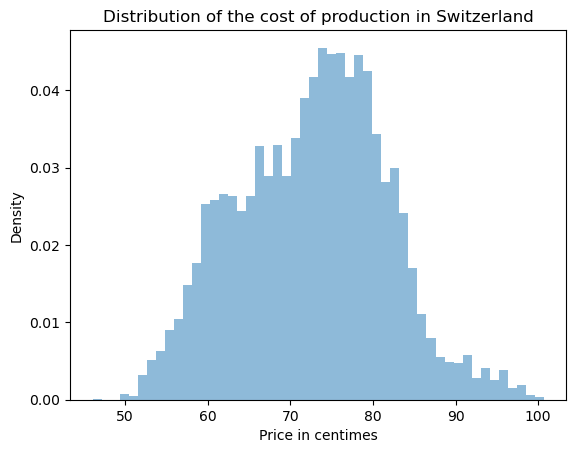

In [16]:
swiss_histogram = pd.read_csv('Swiss_Production.csv')

# plot distribution of the cost of production, all regions combined.
plt.hist(swiss_histogram['Prix'], bins=50, density=True, alpha=0.5)
plt.xlabel('Price in centimes')
plt.ylabel('Density')
plt.title('Distribution of the cost of production in Switzerland')
plt.show()

In [17]:
# Ensemble de couleurs pour différencier chaque région
palette = sns.color_palette("hsv", 5)  # Génère 5 couleurs distinctes

# Création du graphique
plt.figure(figsize=(10, 6))  # Ajustez la taille selon vos besoins

# Boucle sur chaque région unique dans le DataFrame
for i, region in enumerate(swiss_production_data['Provenance du produit'].unique()):
    # Filtrer les données pour chaque région
    subset = swiss_production_data[swiss_production_data['Provenance du produit'] == region]
    # Tracer la distribution des prix pour chaque région
    sns.kdeplot(subset['Prix'], label=region, color=palette[i])

# Ajouter des légendes et titres
plt.title('Distribution de la Densité des Prix par Région')
plt.xlabel('Prix')
plt.ylabel('Densité')
plt.legend(title='Région de Vente')

# Afficher le graphique
plt.show()


TypeError: list indices must be integers or slices, not str

<Figure size 1000x600 with 0 Axes>

Les régions 5 et 1 montrent un prix plus élevé comparé aux autres régions. La région 3 présente le prix le plus bas dans toute la Suisse.

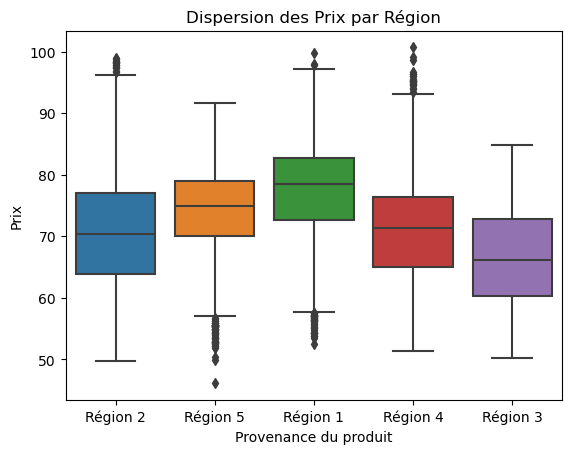

In [ ]:
# plot la dispersion des prix pour chaque région, pour potentiellement permettre d'expliquer cet écart de densité.
sns.boxplot(x='Provenance du produit', y='Prix', data=swiss_production_data)
plt.title('Dispersion des Prix par Région')
plt.show()


Stabilité des prix : Les régions 1 et 3 montrent une plus grande stabilité des prix avec des boîtes plus courtes, indiquant moins de dispersion.

Volatilité des prix : Les régions 5 et 4 présentent une plus grande volatilité des prix comme indiqué par des étendues de prix plus larges et la présence d'outliers.

Distribution de la production de lait pour chaque région suisse.

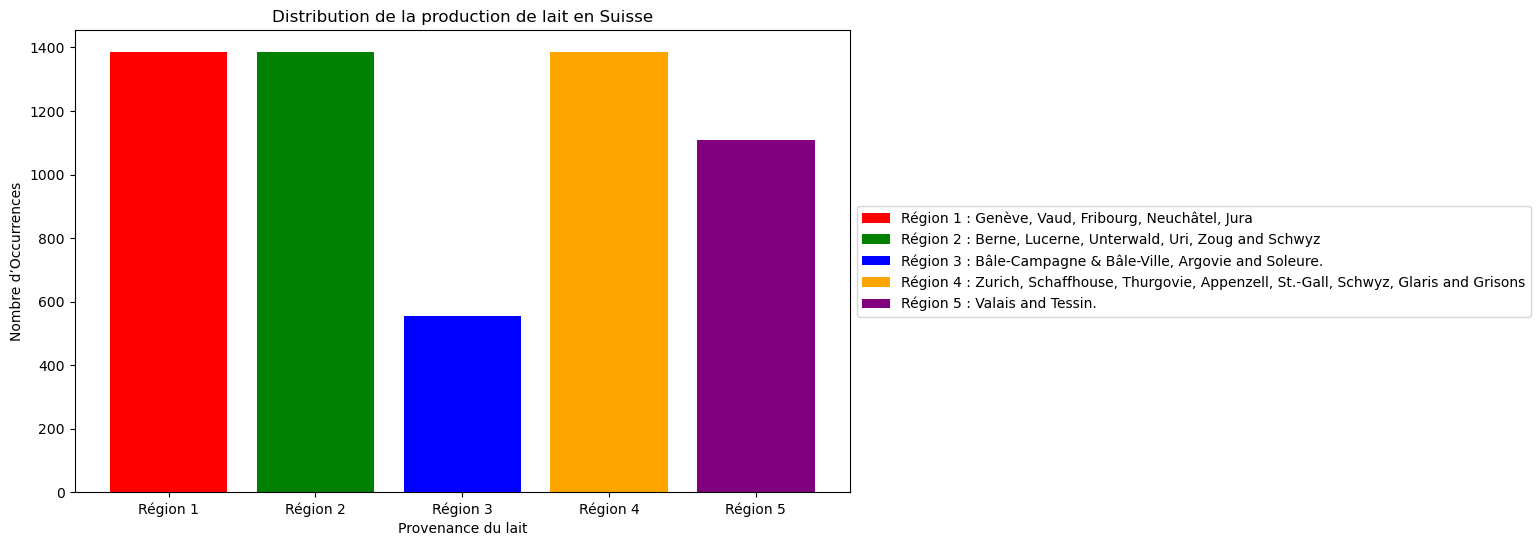

Provenance du produit
Région 1    1385
Région 2    1385
Région 3     554
Région 4    1385
Région 5    1108
Name: count, dtype: int64


In [ ]:
# Compter les occurrences de chaque type de produit
product_counts = swiss_production_data['Provenance du produit'].value_counts()

# Définir l'ordre souhaité des régions
order = ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5']

# Réindexer les données selon l'ordre souhaité
product_counts = product_counts.reindex(order)

# Créer un diagramme à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(product_counts.index, product_counts.values, color=['red', 'green', 'blue', 'orange', 'purple'])

# Descriptions détaillées pour chaque type de produit
labels = ['Région 1 : Genève, Vaud, Fribourg, Neuchâtel, Jura', 
          'Région 2 : Berne, Lucerne, Unterwald, Uri, Zoug and Schwyz', 
          'Région 3 : Bâle-Campagne & Bâle-Ville, Argovie and Soleure.',
          'Région 4 : Zurich, Schaffhouse, Thurgovie, Appenzell, St.-Gall, Schwyz, Glaris and Grisons',
          'Région 5 : Valais and Tessin.']

# Assigner une étiquette à chaque barre pour la légende
for bar, label in zip(bars, labels):
    bar.set_label(label)

# Ajouter la légende
# Ajouter la légende sur le côté gauche
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Ajouter des titres et des étiquettes aux axes
plt.title('Distribution de la production de lait en Suisse')
plt.xlabel('Provenance du lait')
plt.ylabel('Nombre d’Occurrences')

# Afficher le graphique
plt.show()

# Afficher les valeurs exactes de chaque région 
print(product_counts)


Nous pouvons remarquer que les régions 1, 2 et 4 produisent une plus grande quantité de lait par rapport aux régions 3 et 5. 

!!! revoir les labels de chaque région 

MULTIVARIATE VISUALIZATIONS 

Evolution du prix moyen du lait à l'échelle nationale 

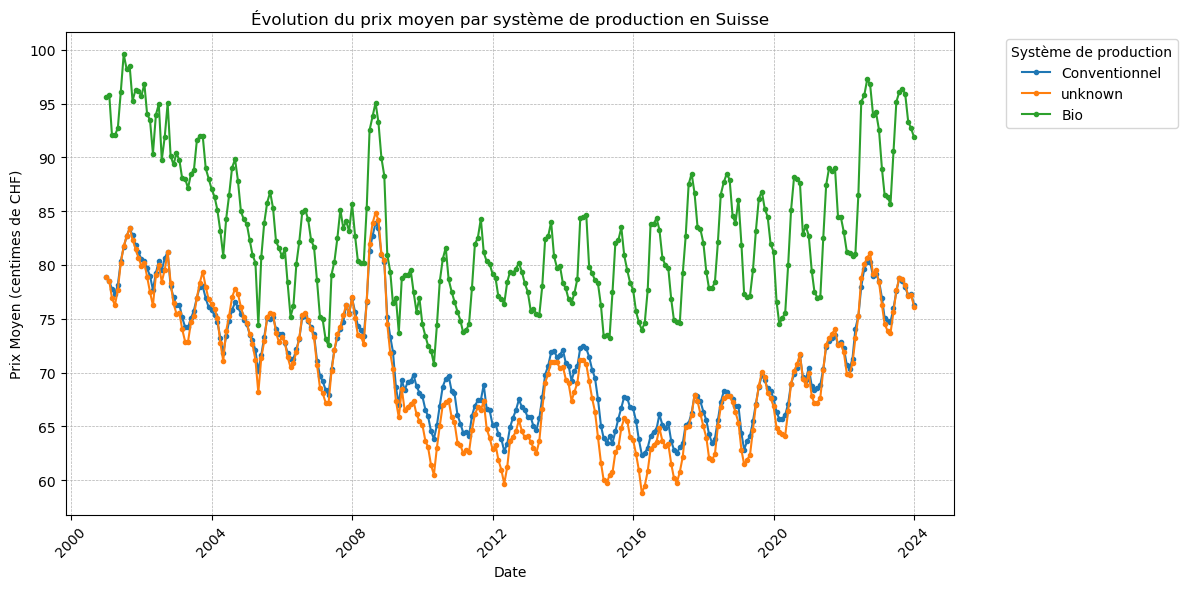

In [ ]:
# plot "l'évolution du prix moyen de production en fonction du système de production"
# Calculer la moyenne des prix pour chaque date et chaque système de production
swiss_production_data_moyenne = swiss_production_data.groupby(['Date', 'Système de production'])['Prix'].mean().reset_index()

# Sélectionner les systèmes de production uniques
systemes_production = swiss_production_data['Système de production'].unique()

# Créer un graphique pour chaque système de production
plt.figure(figsize=(12, 6))  # Ajuste la taille du graphique selon tes besoins

for systeme in systemes_production:

    # Filtrer le DataFrame pour chaque système de production
    swiss_production_data_filtre = swiss_production_data_moyenne[swiss_production_data_moyenne['Système de production'] == systeme]
 
    # Tracer la courbe pour le système de production filtré
    plt.plot(swiss_production_data_filtre['Date'], swiss_production_data_filtre['Prix'],marker='.', linestyle='-', label=systeme)

# Ajout des légendes, titres et étiquettes
plt.title('Évolution du prix moyen par système de production en Suisse')
plt.xlabel('Date')
plt.ylabel('Prix Moyen (centimes de CHF)')
plt.legend(title='Système de production', bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajoute une légende pour distinguer les systèmes et déplace la à l'extérieur
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(rotation=45)  # Rotation des étiquettes pour les rendre lisibles

plt.tight_layout()  # Ajuste la disposition
plt.show()  # Affiche le graphique

Nous pouvons observer que le prix moyen par kg de lait produit est évelé au début des années 2001, environ 80 centimes pour la production de lait conventionnel et plus de 95 centimes pour le lait bio. 

De plus, les données 'unknown' sont fortement corrélées avec les données 'conventionnel'. 

Nous remarquons une saisonalité au niveau des données, avec une trend non linéaire : trend descendante entre 2001 et 2016 et trend ascendante entre 2016 et 2024.

Puis il y a une diminution des prix, bio et conventionnel, jusqu'en 2007 suivi d'un pic en 2008 (potentiel corrélation avec la crise de 2008?) et d'un deuxième en 2014 pour le lait conventionnel. 

A partir de 2020, les prix recommencent à grimper, puis restent plutôt constant sur ces deux dernières années.

Faire forecasting du graphe au-dessus pour bio et conventionnel avec R (et sur 2 ans environ)

Décomposition additive de la production suisse 

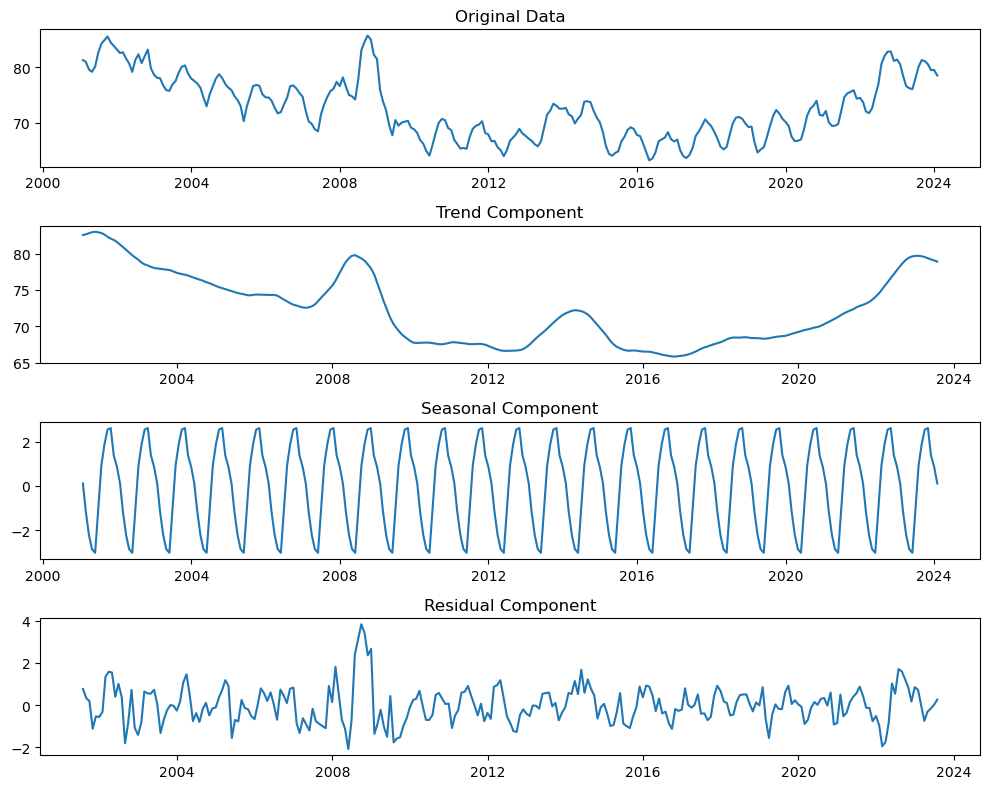

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# import data
swiss_decomposition = pd.read_csv('Swiss_Production.csv')

# Assurez-vous que les dates sont de type datetime et que 'Date' est l'index
swiss_decomposition['Date'] = pd.to_datetime(swiss_decomposition['Date'])
swiss_decomposition.set_index('Date', inplace=True)

# Calculez la moyenne des prix par date
data = swiss_decomposition['Prix'].resample('ME').mean()

# Appliquez la décomposition classique
decomposition = sm.tsa.seasonal_decompose(data, model='additive')  # ou 'multiplicative' selon le cas

# Créez un graphique avec des subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

# Plot the original data
axes[0].plot(data, label='Original')
axes[0].set_title('Original Data')

# Plot the trend component
axes[1].plot(decomposition.trend, label='Trend')
axes[1].set_title('Trend Component')

# Plot the seasonal component
axes[2].plot(decomposition.seasonal, label='Seasonal')
axes[2].set_title('Seasonal Component')

# Plot the residual component
axes[3].plot(decomposition.resid, label='Residual')
axes[3].set_title('Residual Component')

# Set tight layout and show the plot
plt.tight_layout()
plt.show()


No clear trend - decreases and then increases, with two peaks in 2008 and 2014.

Clear seasonal component - due to weather conditions or agricultural cycles.

Residual component - relatively stable, but shows some peaks, which could indicate anomalies or events not taken into account by the trend and seasonality model.

Nous allons ensuite procéder à un modèle SARIMA. Avant d'appliquer ce modèle, il faut vérifier la stationnarité des données (et particulièrement des résidus) et déterminer les valeurs optimales des paramètres du modèle : p, d, q, P, D et Q.
Pour déterminer ces paramètres, nous allons utiliser les graphiques Autocorrelation Function ACF et Partial Autocorrelation Function PACF. Ces graphiques vont nous aider à identifier la structure de dépendance dans les données.

ACF (Autocorrelation Function) : Aide à déterminer l'ordre q (MA). Regardez les lags où l'ACF est significatif.

PACF (Partial Autocorrelation Function) : Aide à déterminer l'ordre p (AR). Regardez les lags où le PACF est significatif.

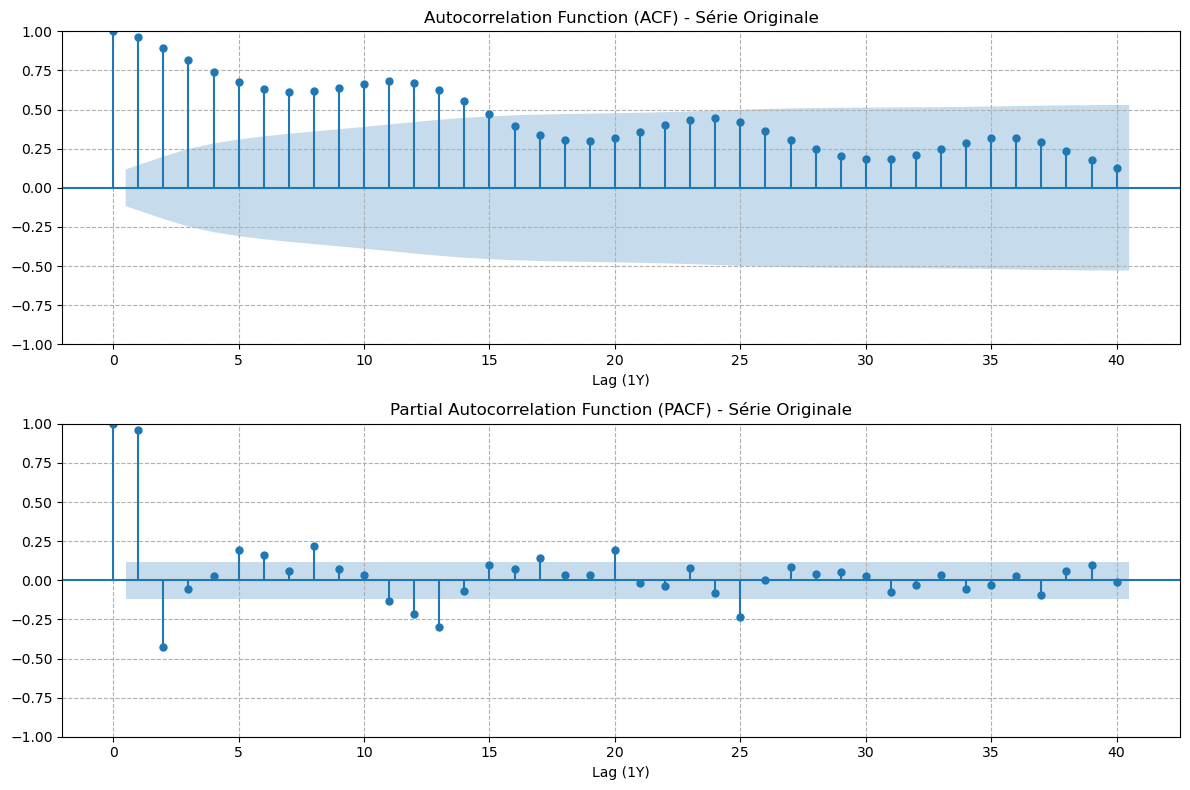

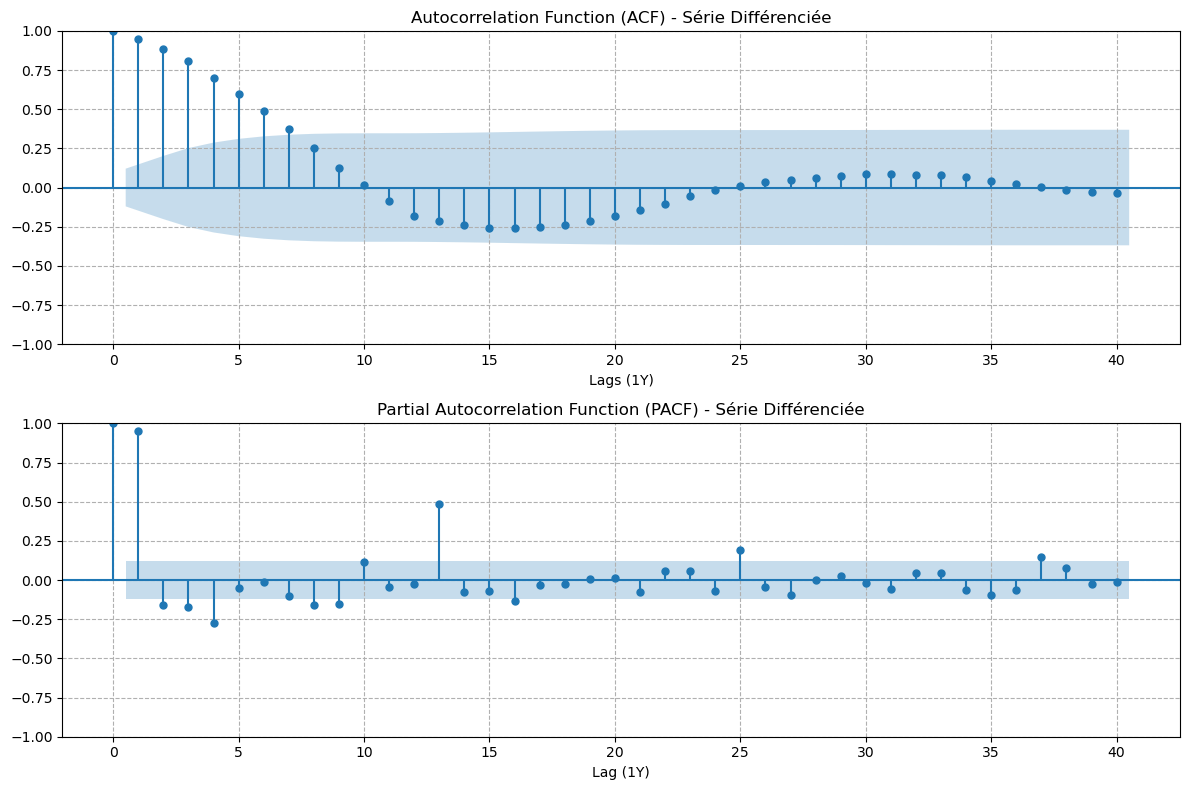

In [11]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importer les données
swiss_decomposition = pd.read_csv('Swiss_Production.csv')

# Assurez-vous que les dates sont de type datetime et que 'Date' est l'index
swiss_decomposition['Date'] = pd.to_datetime(swiss_decomposition['Date'])
swiss_decomposition.set_index('Date', inplace=True)

# Calculez la moyenne des prix par date
data = swiss_decomposition['Prix'].resample('ME').mean()  # Use 'M' for monthly resampling

# Tracer ACF et PACF pour la série originale
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data.dropna(), ax=ax[0], lags=40)
ax[0].set_title('Autocorrelation Function (ACF) - Série Originale')
ax[0].set_xlabel('Lag (1Y)')  # Ajouter le titre de l'axe des abscisses
ax[0].grid(True, linestyle='--')  # Ajouter la grille

plot_pacf(data.dropna(), ax=ax[1], lags=40)
ax[1].set_title('Partial Autocorrelation Function (PACF) - Série Originale')
ax[1].set_xlabel('Lag (1Y)')
ax[1].grid(True, linestyle='--')  # Ajouter la grille

plt.tight_layout()
plt.show()

# Différenciation saisonnière pour supprimer la saisonnalité annuelle
data_seasonal_diff = data.diff(12).dropna()

# Différenciation simple pour supprimer la tendance
data_diff = data_seasonal_diff.diff().dropna()

# Tracer ACF et PACF pour la série différenciée
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data_seasonal_diff, ax=ax[0], lags=40)
ax[0].set_title('Autocorrelation Function (ACF) - Série Différenciée')
ax[0].set_xlabel('Lags (1Y)')  # Ajouter le titre de l'axe des abscisses
ax[0].grid(True, linestyle='--')  # Ajouter la grille

plot_pacf(data_seasonal_diff, ax=ax[1], lags=40)
ax[1].set_title('Partial Autocorrelation Function (PACF) - Série Différenciée')
ax[1].set_xlabel('Lag (1Y)')
ax[1].grid(True, linestyle='--')  # Ajouter la grille

plt.tight_layout()
plt.show()

La zone bleue représente l'intervalle de confiance autout de la ligne de zéro et fixé à 95%. Les valeurs qui dépassent cette zone sont considérées comme statistiquement significatives. Si une des valeurs de notre jeux de données sort de cet intervalle cela signifie que l'autocorrélation est forte (donc significativement différente de zéro).

L'axe des ordonnées représente le coefficient d'autocorrélation et d'autocorrélation partielle.
 
L'axe des abscisse représente le lag. Un lag de 1 signifie que l'autocorrélation est calculée entre les valeurs à des périodes successives.




Les deux premiers graphiques montrent l'ACF et le PACF de la série temporelle originale. 
Les valeurs d'autocorrélation sont significatives pour plusieurs lags, indiquant une tendance ou une composante saisonnière. La décroissance lente suggère que les données ne sont pas stationnaires. La présence d'une autocorrélation significative pour de nombreux lags indique une tendance persistante dans les données. Cela signifie que la série est non stationnaire.
Le PACF montre des pics significatifs aux premiers lags, suivis d'une diminution rapide. Cela suggère que l'effet de l'autocorrélation diminue après quelques lags.
Les premiers lags significatifs dans le PACF suggèrent que quelques termes autorégressifs peuvent être nécessaires pour capturer la structure dans les données.

Les deux derniers graphiques montrent l'ACF et le PACF de la série différenciée.
La série différenciée semble être plus stationnaire, car la plupart des autocorrélations ne sont plus significatives. Cependant, il peut y avoir une légère saisonnalité ou des effets résiduels.
Pour le PACF, les premiers lags montrent quelques valeurs significatives, mais la plupart des valeurs tombent rapidement dans l'intervalle de confiance.
La série différenciée montre une structure autorégressive de faible ordre, suggérant qu'un modèle ARIMA avec de petits paramètres p et q pourrait suffire.


Maintenant que nous avons analyser ces dépendances, nous pouvons fixer les paramètres dont nous avons besoin pour pouvoir appliquer le modèle SARIMA:

Différenciation (d) : Puisque la série originale n'est pas stationnaire et que la série différenciée semble être stationnaire, nous utiliserons d=1.
Ordre autorégressif (p) : Le premier lag dans le PACF est significatif, donc p=1.
Ordre de moyenne mobile (q) : L'ACF montre quelques lags significatifs, mais ils ne sont pas dominants, donc q=1.

Pour les composantes saisonnières :
Différenciation saisonnière (D) : Les données montrent une saisonnalité, nous utilisons donc D=1.
Ordre autorégressif saisonnier (P) : Les premiers lags dans le PACF saisonnier montrent une légère significativité, donc P=1.
Ordre de moyenne mobile saisonnier (Q) : Similaire à q, nous utilisons Q=1.
Période saisonnière (S) : Comme les données sont mensuelles, nous utilisons S=12.

ACF & PACF for "Bio" and "Conventionnel"

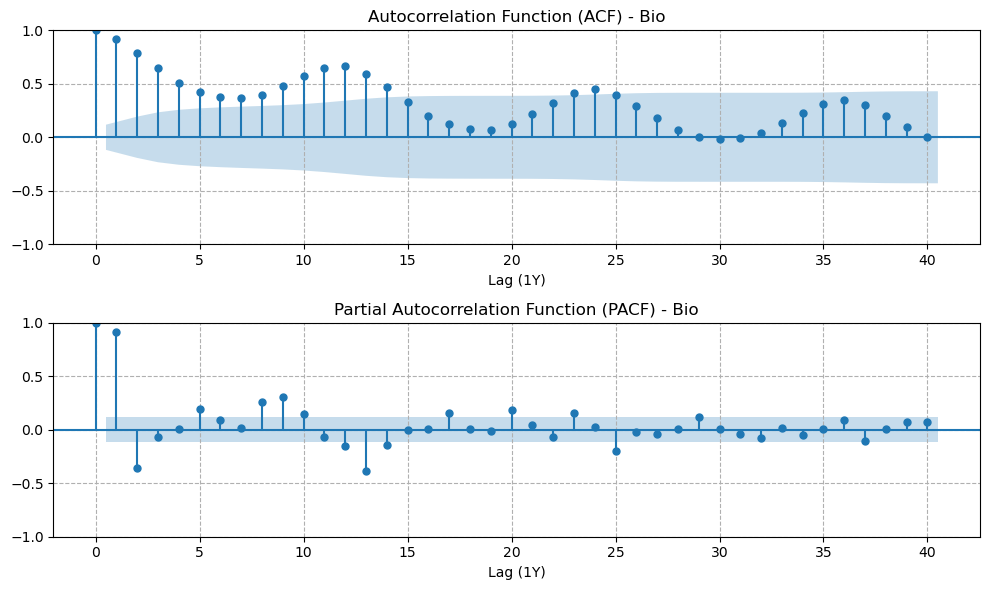

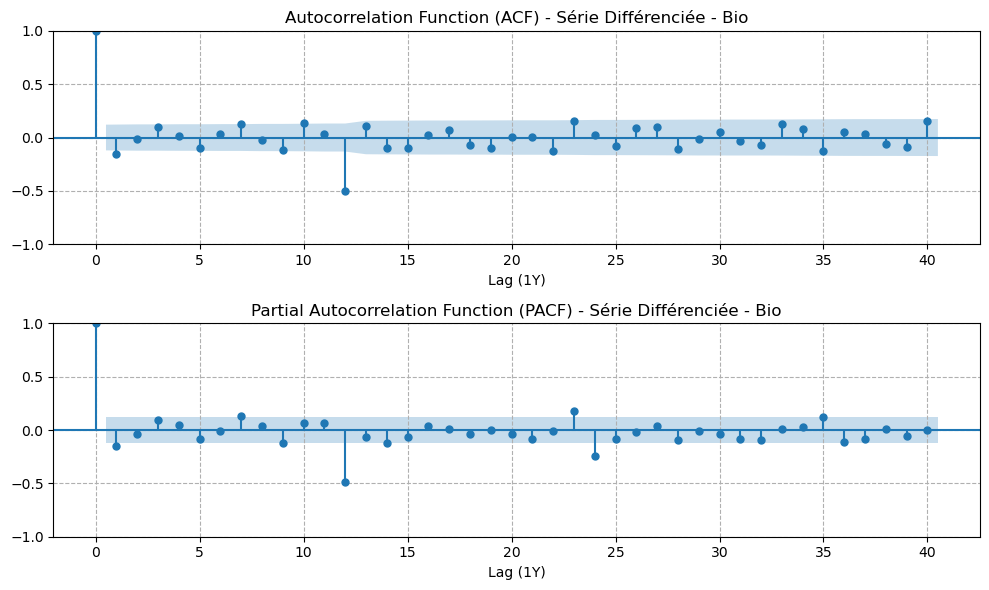

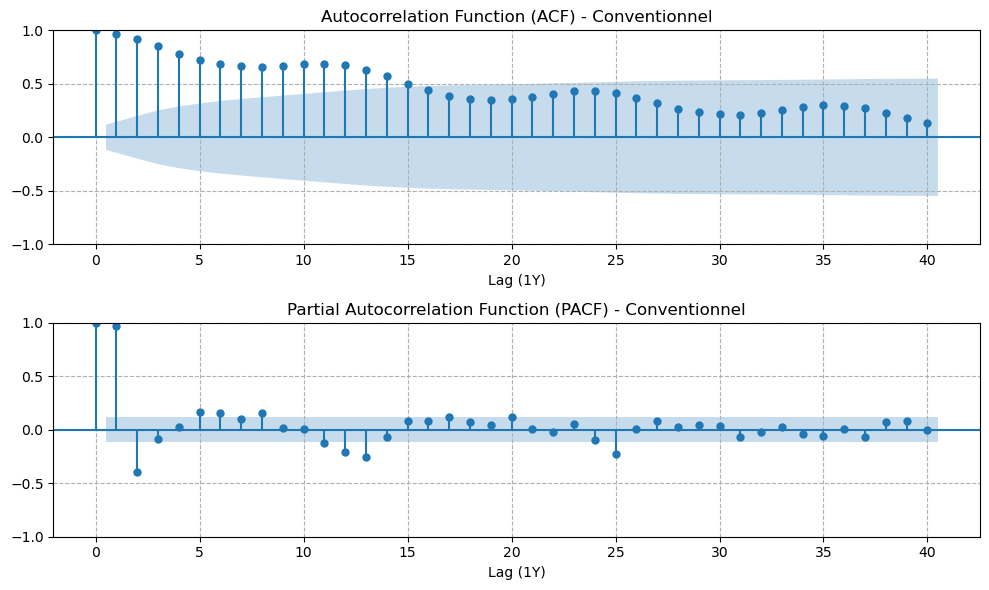

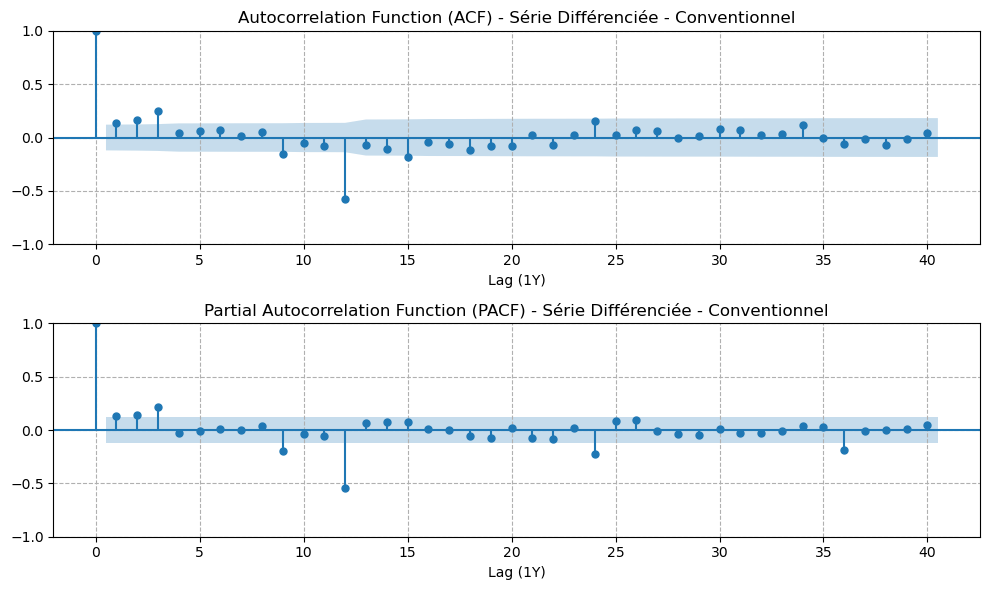

In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importer les données
swiss_decomposition = pd.read_csv('Swiss_Production.csv')

# Assurez-vous que les dates sont de type datetime et que 'Date' est l'index
swiss_decomposition['Date'] = pd.to_datetime(swiss_decomposition['Date'])
swiss_decomposition.set_index('Date', inplace=True)

# Définir les systèmes de production
systemes_production = ['Bio', 'Conventionnel']

# Créer un graphique pour chaque système de production
for systeme in systemes_production:
    # Filtrer le DataFrame pour chaque système de production
    system_data = swiss_decomposition[swiss_decomposition['Système de production'] == systeme]
    
    # Calculez la moyenne des prix par date pour ce système
    system_data = system_data['Prix'].resample('ME').mean().dropna()
    
    # Tracer ACF et PACF pour la série originale
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(system_data, ax=ax[0], lags=40)
    ax[0].set_title(f'Autocorrelation Function (ACF) - {systeme}')
    ax[0].set_xlabel('Lag (1Y)')
    ax[0].grid(True, linestyle='--')
    
    plot_pacf(system_data, ax=ax[1], lags=40)
    ax[1].set_title(f'Partial Autocorrelation Function (PACF) - {systeme}')
    ax[1].set_xlabel('Lag (1Y)')
    ax[1].grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Différenciation saisonnière pour supprimer la saisonnalité annuelle
    system_seasonal_diff = system_data.diff(12).dropna()
    
    # Différenciation simple pour supprimer la tendance
    system_diff = system_seasonal_diff.diff().dropna()
    
    # Tracer ACF et PACF pour la série différenciée
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(system_diff, ax=ax[0], lags=40)
    ax[0].set_title(f'Autocorrelation Function (ACF) - Série Différenciée - {systeme}')
    ax[0].set_xlabel('Lag (1Y)')
    ax[0].grid(True, linestyle='--')
    
    plot_pacf(system_diff, ax=ax[1], lags=40)
    ax[1].set_title(f'Partial Autocorrelation Function (PACF) - Série Différenciée - {systeme}')
    ax[1].set_xlabel('Lag (1Y)')
    ax[1].grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

In [20]:
# Vérifiez l'installation de pmdarima
try:
    import pmdarima as pm
    print("pmdarima is installed and imported successfully!")
except ImportError:
    import sys
    !{sys.executable} -m pip install pmdarima
    import pmdarima as pm
    print("pmdarima has been installed and imported successfully!")

  Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.4 MB/s eta 0:00:0000:0100:01
Using cached Cython-3.0.10-py2.py3-none-any.whl (1.2 MB)
pmdarima has been installed and imported successfully!


SARIMA FORECAST OF EACH SYSTEM OF PRODUCTION

/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_57445/2173351569.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_data = pd.DataFrame(index=pd.date_range(start=swiss_decomposition.index[-1] + pd.Timedelta(days=1), periods=12, freq='M'))
/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_57445/2173351569.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  system_data = system_data['Prix'].resample('M').mean().dropna()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1282.562, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1127.692, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1193.607, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1280.570, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1251.292, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1045.504, Time=0.67 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1192.509, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1046.696, Time=0.90 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1046.817, Time=0.54 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1162.038, Time=0.23 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=1048.626, Time=0.93 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

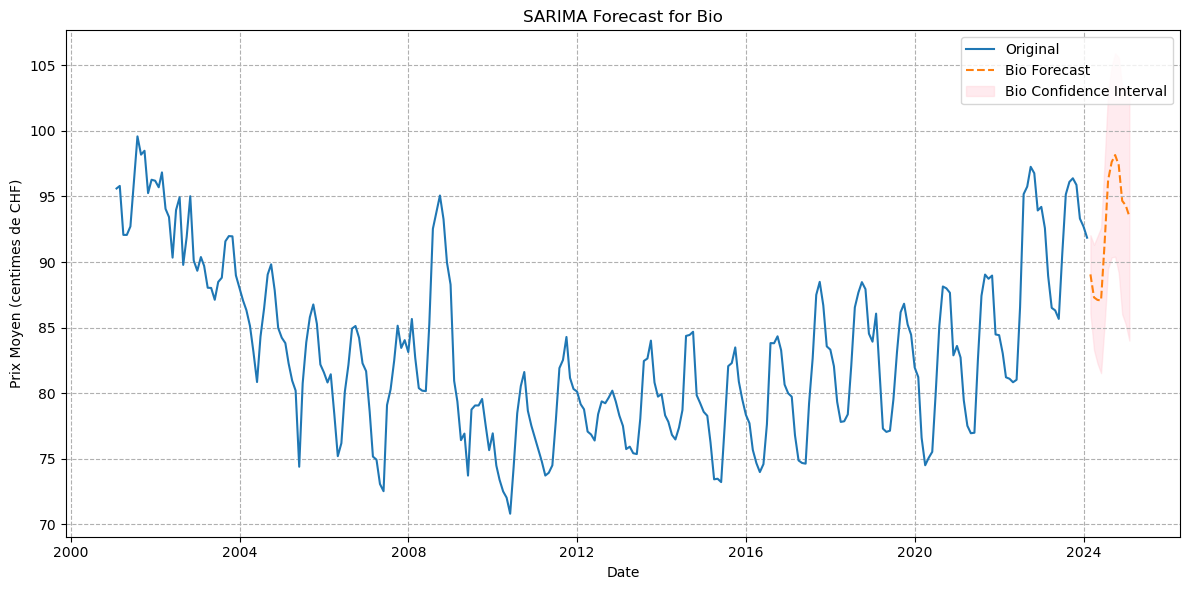

/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_57445/2173351569.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  system_data = system_data['Prix'].resample('M').mean().dropna()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=717.305, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=891.795, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=786.354, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=817.650, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=889.811, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=741.770, Time=0.64 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=777.177, Time=0.57 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=710.513, Time=1.55 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=718.036, Time=1.70 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=710.704, Time=1.58 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=714.933, Time=1.80 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=707.322, Time=1.28 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=709.737, Time=0.58 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=728.559, Time=0.63 sec
 ARIMA(1,1,2)(2,0,2)[12] intercep

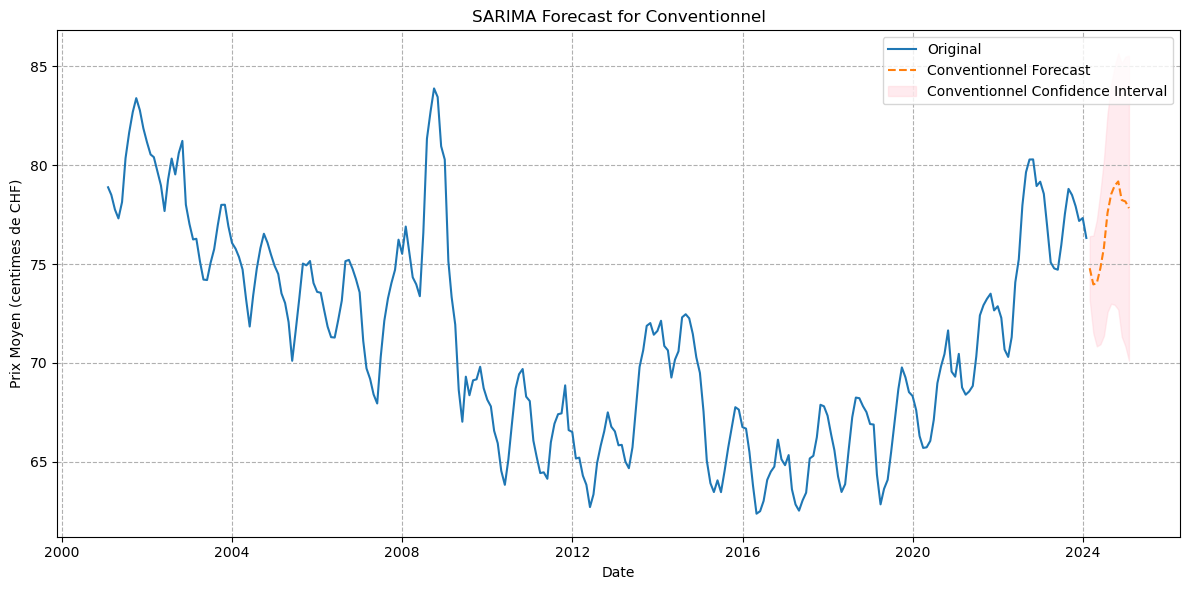

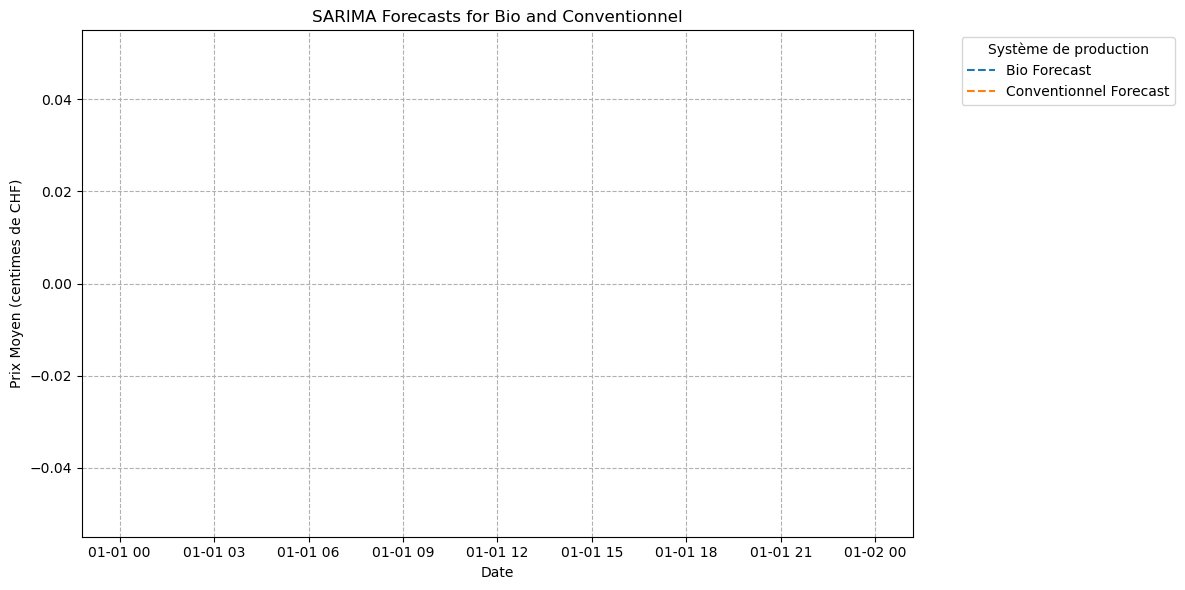

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Importer les données
swiss_decomposition = pd.read_csv('Swiss_Production.csv')

# Assurez-vous que les dates sont de type datetime et que 'Date' est l'index
swiss_decomposition['Date'] = pd.to_datetime(swiss_decomposition['Date'])
swiss_decomposition.set_index('Date', inplace=True)

# Définir les systèmes de production
systemes_production = ['Bio', 'Conventionnel']

# Préparer le DataFrame pour stocker les prévisions
forecast_data = pd.DataFrame(index=pd.date_range(start=swiss_decomposition.index[-1] + pd.Timedelta(days=1), periods=12, freq='M'))

# Liste pour stocker les modèles ajustés
fitted_models = []

# Créer un graphique pour chaque système de production
for systeme in systemes_production:
    # Filtrer le DataFrame pour chaque système de production
    system_data = swiss_decomposition[swiss_decomposition['Système de production'] == systeme]
    
    # Calculez la moyenne des prix par date pour ce système
    system_data = system_data['Prix'].resample('M').mean().dropna()
    
    # Utiliser auto_arima pour déterminer les meilleurs paramètres
    auto_model = pm.auto_arima(system_data, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    print(f'Auto ARIMA summary for {systeme}:\n{auto_model.summary()}')
    
    # Ajustement du modèle SARIMA avec les paramètres déterminés
    sarima_model = SARIMAX(system_data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    fit_sarima = sarima_model.fit(disp=False)
    fitted_models.append(fit_sarima)

    # Prévision
    forecast = fit_sarima.get_forecast(steps=12)
    sarima_forecast = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Ajouter les prévisions au DataFrame de prévision
    forecast_data[systeme] = sarima_forecast

    # Tracer les prévisions
    plt.figure(figsize=(12, 6))
    plt.plot(system_data, label='Original')
    plt.plot(sarima_forecast.index, sarima_forecast, linestyle='--', label=f'{systeme} Forecast')
    plt.fill_between(sarima_forecast.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label=f'{systeme} Confidence Interval')
    plt.title(f'SARIMA Forecast for {systeme}')
    plt.xlabel('Date')
    plt.ylabel('Prix Moyen (centimes de CHF)')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()


SARIMA OVERALL FORECAST

/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


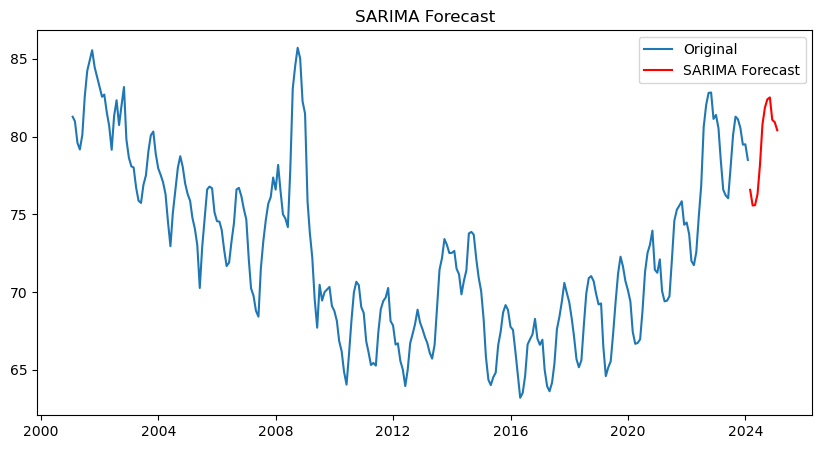

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustement du modèle SARIMA avec les paramètres déterminés
sarima_model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarima = sarima_model.fit(disp=False)

# Prévision
sarima_forecast = fit_sarima.get_forecast(steps=12).predicted_mean

# Tracer les résultats
plt.figure(figsize=(10, 5))
plt.plot(data, label='Original')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

Nous allons quand même appliquer auto_arima pour déterminer les meilleurs paramètres possibles et pour s'assurer d'être juste au niveau des paramètres que nous avons déterminés au-dessus visuellement. La fonction auto_arima explore les différentes combinaisons de paramètres pour minimiser le critère AIC.


Le code ne marche pas - trouver l'erreur ou enlever : le package pmdarima ne veut pas marcher.

EXPONENTIAL SMOOTHING 

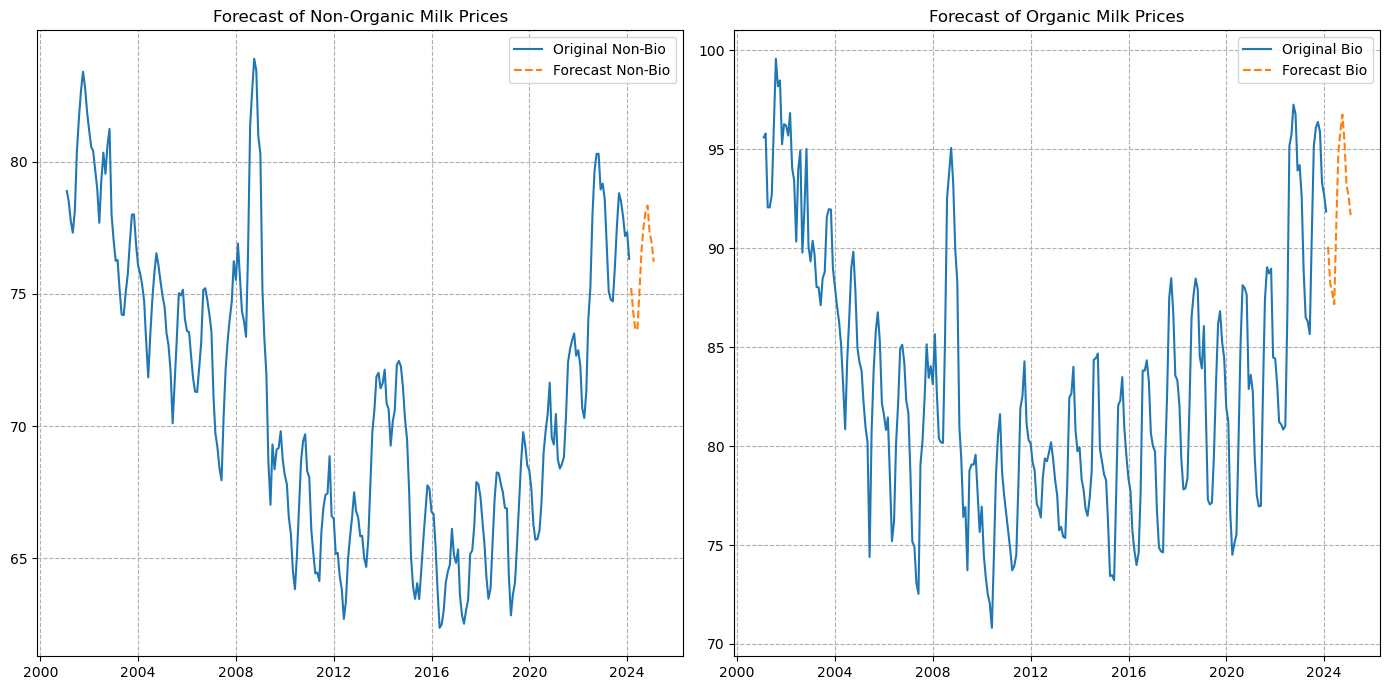

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Charger les données
data = pd.read_csv('Swiss_Production.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filtrer les données pour le lait bio et non bio
data_bio = data[data['Système de production'] == 'Bio']['Prix'].resample('ME').mean()
data_non_bio = data[data['Système de production'] == 'Conventionnel']['Prix'].resample('ME').mean()

# Ajustement des modèles ETS
model_bio = ExponentialSmoothing(data_bio, trend='add', seasonal='add', seasonal_periods=12)
fit_bio = model_bio.fit()

model_non_bio = ExponentialSmoothing(data_non_bio, trend='add', seasonal='add', seasonal_periods=12)
fit_non_bio = model_non_bio.fit()

# Prévision pour les 24 prochains mois
forecast_bio = fit_bio.forecast(12)
forecast_non_bio = fit_non_bio.forecast(12)

# Tracer les résultats
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(data_non_bio, label='Original Non-Bio')
plt.plot(forecast_non_bio, label='Forecast Non-Bio', linestyle='--')
plt.title('Forecast of Non-Organic Milk Prices')
plt.grid(True, linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data_bio, label='Original Bio')
plt.plot(forecast_bio, label='Forecast Bio', linestyle='--')
plt.title('Forecast of Organic Milk Prices')
plt.grid(True, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

Nous appliquons le modèle Holt-Winters pour prédire le prix sur les 12 prochains mois. Ce modèle est une extension du modèle de lissage exponentiel simple. Il prend en compte la tendance et la saisonnalité dans ses prédictions pour ses deux series temporelles, étant donné que ces deux composantes jouent un rôle crucial comme nous l'avons vu avec la décomposition | We apply the Holt-Winters model to predict the price over the next 12 months. This model is an extension of the simple exponential smoothing model. It takes trend and seasonality into account in its predictions for its two time series, since these two components play a crucial role as we have seen with the decomposition. 

exponential smoothing with interval confidence

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Charger les données
data = pd.read_csv('Swiss_Production.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filtrer les données pour le lait bio et non bio
data_bio = data[data['Système de production'] == 'Bio']['Prix'].resample('M').mean()
data_non_bio = data[data['Système de production'] == 'Conventionnel']['Prix'].resample('M').mean()

# Ajustement des modèles ETS
model_bio = ExponentialSmoothing(data_bio, trend='add', seasonal='add', seasonal_periods=12)
fit_bio = model_bio.fit()

model_non_bio = ExponentialSmoothing(data_non_bio, trend='add', seasonal='add', seasonal_periods=12)
fit_non_bio = model_non_bio.fit()

# Prévision pour les 12 prochains mois
forecast_bio = fit_bio.forecast(12)
forecast_non_bio = fit_non_bio.forecast(12)

# Bootstrap pour les intervalles de confiance
def forecast_with_conf_int(model, steps, n_simulations=1000, alpha=0.05):
    simulations = np.zeros((n_simulations, steps))
    for i in range(n_simulations):
        simulated_data = model.simulate(nsimulations=steps)
        simulations[i, :] = model.forecast(steps=steps, simulate_data=simulated_data)
    lower_bound = np.percentile(simulations, 100 * alpha / 2.0, axis=0)
    upper_bound = np.percentile(simulations, 100 * (1 - alpha / 2.0), axis=0)
    return lower_bound, upper_bound

conf_int_bio = forecast_with_conf_int(fit_bio, 12)
conf_int_non_bio = forecast_with_conf_int(fit_non_bio, 12)

# Tracer les résultats
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(data_non_bio, label='Original Non-Bio')
plt.plot(forecast_non_bio, label='Forecast Non-Bio', linestyle='--')
plt.fill_between(forecast_non_bio.index, conf_int_non_bio[0], conf_int_non_bio[1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Forecast of Non-Organic Milk Prices')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data_bio, label='Original Bio')
plt.plot(forecast_bio, label='Forecast Bio', linestyle='--')
plt.fill_between(forecast_bio.index, conf_int_bio[0], conf_int_bio[1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Forecast of Organic Milk Prices')
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_57445/3235000101.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_bio = data[data['Système de production'] == 'Bio']['Prix'].resample('M').mean()
/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_57445/3235000101.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_non_bio = data[data['Système de production'] == 'Conventionnel']['Prix'].resample('M').mean()


TypeError: HoltWintersResults.forecast() got an unexpected keyword argument 'simulate_data'

Prix moyen de la production de lait, en fonction de la région et du système de production

In [ ]:
# Vérifiez et triez les données par année si nécessaire.
swiss_production_data = pd.read_csv('Swiss_Production.csv')
swiss_production_data['Date'] = pd.to_datetime(swiss_production_data['Date']).dt.year
swiss_production_data = swiss_production_data[swiss_production_data['Date'].between(2001, 2024)]

# Assurez-vous que les données sont triées par 'Provenance du Lait' puis par 'Date'.
swiss_production_data.sort_values(by=['Provenance du produit', 'Date'], inplace=True)

# Définir explicitement l'ordre des catégories pour 'Provenance du Lait'.
swiss_production_data['Provenance du produit'] = pd.Categorical(swiss_production_data['Provenance du produit'],
                                                             categories=['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5'],
                                                             ordered=True)

# Conversion de la colonne 'Date' en type datetime
# Remplacez 'format' par le format correct de vos dates, par exemple '%m-%Y' si vos dates sont sous la forme '01-2024'
#swiss_production_data['Date'] = pd.to_datetime(swiss_production_data['Date'], format='%m-%y', errors='coerce') # l'option 'coerce' permet de gérer les valeurs qui ne peuvent pas être converties en date, remplacées par NaT (not a time).

# Groupez et calculez le prix moyen, en passant observed=True pour inclure uniquement les catégories observées
#prix_moyen = swiss_production_data.groupby(['Provenance du produit', 'Système de production', 'Date'], observed=True)['Prix'].mean().reset_index()

# Créez le graphique avec Plotly Express.
fig = px.bar(
    swiss_production_data, 
    x='Provenance du produit', 
    y='Prix', 
    color='Système de production', 
    barmode='group',
    animation_frame='Date',
     category_orders={"Provenance du Lait": ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5']}
)

# Mise à jour des titres.
fig.update_layout(
    title_text='Prix moyen de la production de lait, en fonction de la région et du système de production',
    xaxis_title='Provenance du Lait',
    yaxis_title='Prix Moyen en centimes',
)

# Ajouter des détails de hover.
fig.update_traces(
    hovertemplate='Provenance du produit: %{x}<br>Système de production: %{marker.color}<br>Date: %{animation_frame}<br>Prix:%{y}'
)

# Créez des étapes pour le slider.
years = swiss_production_data['Date'].unique()
steps = []
for year in years:
    step = dict(
        method='animate',
        label=str(year),
        args=[[str(year)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate'}]
    )
    steps.append(step)

# Ajoutez le slider à la figure.
fig.update_layout(
    sliders=[{'steps': steps}]
)

# Supprimez le bouton de lecture automatique.
fig.layout.updatemenus[0].buttons = []

# Affichez le graphique.
fig.show()

Nous pouvons observer que les régions 5 et 3 ne produisent pas de lait bio depuis les années 2001. De plus, la région 3 produit moins de lait en moyenne.

Evolution du prix moyen du lait à l'échelle internationale 

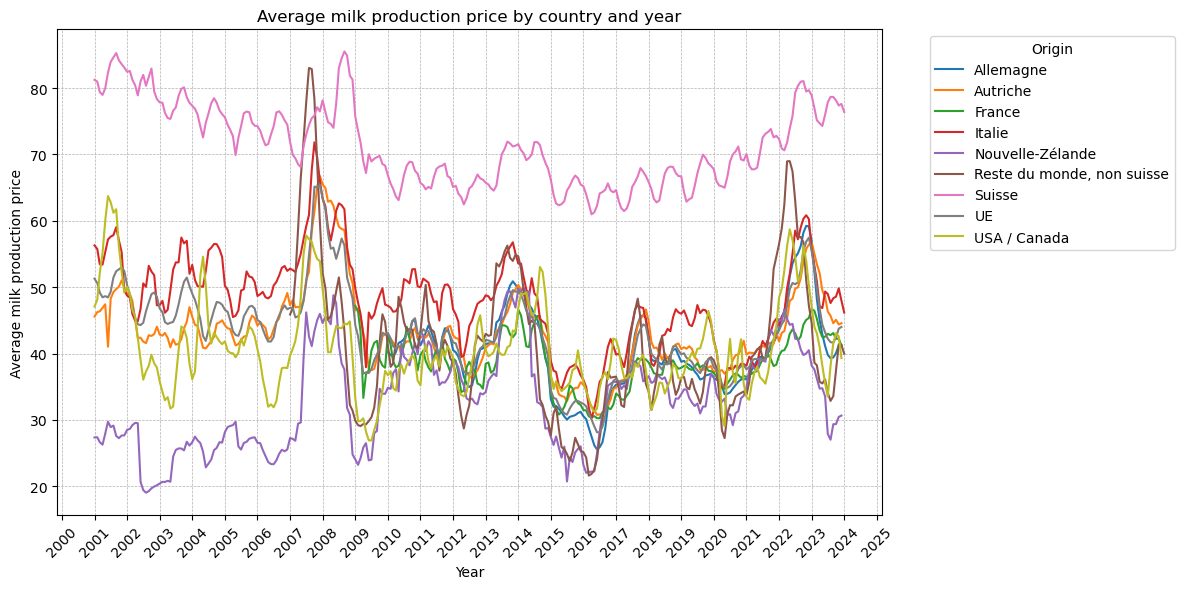

In [ ]:
# Convert date from string to datetime
clean_data['Date'] = pd.to_datetime(clean_data['Date']) 

# Remplacer les noms des pays par 'Groupe'
clean_data['Provenance du produit'] = clean_data['Provenance du produit'].replace(swiss_production_data, 'Suisse')

# Grouper les données par 'Provenance du produit' et 'Date', puis calculer la moyenne des prix 
prix_moyen_par_pays_et_annee = clean_data.groupby(['Provenance du produit', 'Date'])['Prix'].mean().reset_index()

# Préparer la figure
plt.figure(figsize=(12, 6))

# Boucler sur chaque pays pour le tracer
for pays in prix_moyen_par_pays_et_annee['Provenance du produit'].unique():
    subset = prix_moyen_par_pays_et_annee[prix_moyen_par_pays_et_annee['Provenance du produit'] == pays]
    plt.plot(subset['Date'], subset['Prix'], label=pays)

# Ajouter des légendes et titres
plt.legend()
plt.title('Average milk production price by country and year')
plt.xlabel('Year')
plt.ylabel('Average milk production price')
plt.legend(title='Origin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45) # Pour une meilleure lisibilité des dates
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Utilisation des locators et formatters pour l'axe des x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Un tick par année
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Afficher seulement l'année

plt.tight_layout()  # Ajuste la disposition
plt.show()

Nous pouvons observer que la production de lait coûte bien plus cher pour la Suisse que pour les autres pays.